# Neural Networks Project - Gesture Recognition

### Problem Statement

Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:
 Each gesture corresponds to a specific command:

| Gesture | Corresponding Action |
        | --- | --- | 
| Thumbs Up | Increase the volume. |
| Thumbs Down | Decrease the volume. |
| Left Swipe | 'Jump' backwards 10 seconds. |
| Right Swipe | 'Jump' forward 10 seconds. |
| Stop | Pause the movie. |

Each video is a sequence of 30 frames (or images).

 ### There are a few key things to note about the conv-RNN architecture:

- You can use transfer learning in the 2D CNN layer rather than training your own CNN 
- GRU can be a better choice than an LSTM since it has lesser number of gates (and thus parameters)

### Objectives:
1. **Generator**:  The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

2. **Model**: Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. As suggested by Snehansu, start training on a small amount of data and then proceed further.

3. **Write up**: This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model. 



In [2]:
## Importing the necessary libraries
import numpy as np
import os
#from scipy.misc import imread, imresize
import cv2
import datetime
import os
import abc
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
#from keras.layers.convolutional import Conv3D, MaxPooling3D # remove convolution from here
from keras.layers import Dropout
from keras.layers import Conv3D,MaxPooling3D,Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense

In [4]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [5]:
np.random.seed(30)
import random as rn
rn.seed(30)
#from keras import backend as K
import tensorflow as tf
#tf.set_random_seed(30)          #The set_random_seed function was deprecated in TensorFlow 2.x, replaced by tf.random.set_seed.
tf.random.set_seed(30)
import tensorflow as tf


In [6]:
project_folder='datasets/Project_data'


In [7]:
# Function to plot training and validation accuracies and losses.

def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].grid()
    axes[0].legend(['loss','val_loss'])
    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].grid()
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

In [45]:
# ModelBuilder class consisiting path,image and hyperparameter initialisation function
# Generator function and model train function

class ModelBuilder(metaclass= abc.ABCMeta):
    # initialisng the path where project data resides
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
    # initialising the image properties    
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
    # initialising the batch size, frames to sample and the no. of epochs
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
    # MOST IMPORTANT PART HERE - The generator function   
    
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx):
                #performing image reading and resizing
                image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized = cv2.resize(image, (self.image_width, self.image_height))
               
                #normalizing the images
                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    # cropping the images to have the targeted gestures and remove the noise from the images.
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=cv2.resize(cropped,(self.image_width, self.image_height))
                    
                    
            
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        #filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_categorical_accuracy:.5f}.h5'
        print('model saved to :',filepath)
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq='epoch')# period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        
        #earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
        callbacks_list = [checkpoint, LR]#, earlystop]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, initial_epoch=0)
        print('model saved to :',filepath)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

#### Generator

This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with img_idx, y,z and normalization such that you get high accuracy.

## Model

Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [9]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        #optimiser = keras.optimizers.Adam()
        optimiser = "adam"
        #optimiser = 'sgd'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [10]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=1)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 160, 160, 16)  1312      
                                                                 
 activation (Activation)     (None, 30, 160, 160, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 30, 160, 160, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 80, 80, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 80, 80, 32)    4128      
                                                                 
 activation_1 (Activation)   (None, 15, 80, 80, 32)    0

2024-05-01 09:59:04.255253: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-05-01 09:59:04.255326: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1d:00.0, compute capability: 7.5


##### Sample Cropping

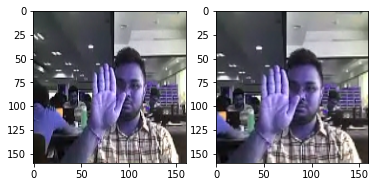

In [12]:
test_generator=ModelConv3D1()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=160,image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,15,:,:,:])   
axes[1].imshow(batch_data[3,15,:,:,:])   
plt.show()

In [93]:
conv_3d1.train_model(conv_3d1_model)

model saved to : model_init_2024-05-0107_40_40.142824/model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_categorical_accuracy:.5f}.h5
67/67 [==============================] - ETA: 0s - loss: 1.6344 - categorical_accuracy: 0.3710
Epoch 00001: val_loss improved from inf to 7.13601, saving model to model_init_2024-05-0107_40_40.142824/model-00001-1.63443-0.37104-0.18000.h5
67/67 [==============================] - 60s 884ms/step - loss: 1.6344 - categorical_accuracy: 0.3710 - val_loss: 7.1360 - val_categorical_accuracy: 0.1800 - lr: 0.0010
model saved to : model_init_2024-05-0107_40_40.142824/model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_categorical_accuracy:.5f}.h5


##### Below are the experiments to see how training time is affected by image resolution, number of images in sequence and batch size

In [95]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=20,batch_size=30,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
model saved to : model_init_2024-05-0107_41_41.701109/model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_categorical_accuracy:.5f}.h5
Epoch 1/2
23/23 [==============================] - ETA: 0s - loss: 1.6493 - categorical_accuracy: 0.3982
Epoch 00001: val_loss improved from inf to 2.38681, saving model to model_init_2024-05-0107_41_41.701109/model-00001-1.64927-0.39819-0.20000.h5
23/23 [==============================] - 31s 1s/step - loss: 1.6493 - categorical_accuracy: 0.3982 - val_loss: 2.3868 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/2
23/23 [==============================] - ETA: 0s - loss: 1.1922 - categorical_accuracy: 0.5415
Epoch 00002: val_loss did not improve from 2.38681
23/23 [==============================] - 30s 1s/step - loss: 1.1922 - categorical_accuracy: 0.5415 - val_loss: 4.1239 - val_categorical_accuracy: 0.1500 - lr: 0.0010
model saved to : model_init_2024-05-0107_41_41.701109/model-{epoch:05d}-{loss:.5f}-{categorical_ac

In [96]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=15,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
model saved to : model_init_2024-05-0107_42_44.205798/model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_categorical_accuracy:.5f}.h5
Epoch 1/2
44/45 [============================>.] - ETA: 1s - loss: 1.4602 - categorical_accuracy: 0.4515
Epoch 00001: val_loss improved from inf to 6.31076, saving model to model_init_2024-05-0107_42_44.205798/model-00001-1.46043-0.45098-0.21000.h5
45/45 [==============================] - 59s 1s/step - loss: 1.4604 - categorical_accuracy: 0.4510 - val_loss: 6.3108 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/2
45/45 [==============================] - ETA: 0s - loss: 1.0391 - categorical_accuracy: 0.5611
Epoch 00002: val_loss did not improve from 6.31076
45/45 [==============================] - 57s 1s/step - loss: 1.0391 - categorical_accuracy: 0.5611 - val_loss: 8.7432 - val_categorical_accuracy: 0.2100 - lr: 0.0010
model saved to : model_init_2024-05-0107_42_44.205798/model-{epoch:05d}-{loss:.5f}-{categorical_a

In [97]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
model saved to : model_init_2024-05-0107_44_41.608510/model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_categorical_accuracy:.5f}.h5
Epoch 1/2
23/23 [==============================] - ETA: 0s - loss: 1.6434 - categorical_accuracy: 0.4163
Epoch 00001: val_loss improved from inf to 3.23454, saving model to model_init_2024-05-0107_44_41.608510/model-00001-1.64343-0.41629-0.16000.h5
23/23 [==============================] - 34s 1s/step - loss: 1.6434 - categorical_accuracy: 0.4163 - val_loss: 3.2345 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/2
22/23 [===========================>..] - ETA: 1s - loss: 1.0430 - categorical_accuracy: 0.6197
Epoch 00002: val_loss did not improve from 3.23454
23/23 [==============================] - 34s 2s/step - loss: 1.0486 - categorical_accuracy: 0.6169 - val_loss: 6.4018 - val_categorical_accuracy: 0.1100 - lr: 0.0010
model saved to : model_init_2024-05-0107_44_41.608510/model-{epoch:05d}-{loss:.5f}-{categorical_a

- As we see from the above experiments **"image resolution"** and **number of frames** in sequence have more impact on training time than **batch_size**
- We can consider the Batch Size around 15-40
- We will change the resoulution 160 * 160, 120 * 120 according the model performance

## Model 1 (Base Model)

- Batch Size = 40 
- No. of Epochs = 20

In [98]:
class ModelConv3D1(ModelBuilder):
    
    #def define_model(self, filtersize=(3, 3, 3), dense_neurons=64,dropout=0.25):
    def define_model(self, filtersize=(3, 3, 3), dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = "adam"
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [99]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=20,batch_size=40,num_epochs=20)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_48 (Conv3D)          (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_48 (Activation)  (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_92 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_48 (MaxPoolin  (None, 10, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_49 (Conv3D)          (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_49 (Activation)  (None, 10, 80, 80, 32)  

In [100]:
print("Total Params:", conv_3d1_model.count_params())
history_model1 = conv_3d1.train_model(conv_3d1_model)

Total Params: 1117061
model saved to : model_init_2024-05-0107_47_10.328271/model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_categorical_accuracy:.5f}.h5
Epoch 1/20
17/17 [==============================] - ETA: 0s - loss: 1.4616 - categorical_accuracy: 0.4314
Epoch 00001: val_loss improved from inf to 1.69774, saving model to model_init_2024-05-0107_47_10.328271/model-00001-1.46160-0.43137-0.24000.h5
17/17 [==============================] - 56s 3s/step - loss: 1.4616 - categorical_accuracy: 0.4314 - val_loss: 1.6977 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/20
17/17 [==============================] - ETA: 0s - loss: 0.9793 - categorical_accuracy: 0.6425
Epoch 00002: val_loss did not improve from 1.69774
17/17 [==============================] - 39s 2s/step - loss: 0.9793 - categorical_accuracy: 0.6425 - val_loss: 2.3640 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/20
17/17 [==============================] - ETA: 0s - loss: 0.6668 - categorical_accura

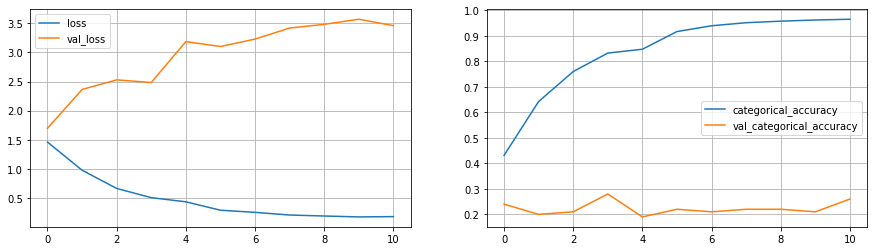

In [102]:
plot(history_model1)

#### Model is clearly overfitting. Lets add dropout layer in next model

## Model 2 
### Adding dropout layers 

- Batch Size = 20 
- No. of Epochs = 25

In [103]:
conv_3d2=ModelConv3D1()
conv_3d2.initialize_path(project_folder)
conv_3d2.initialize_image_properties(image_height=160,image_width=160)
conv_3d2.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=25)
#conv_3d2_model=conv_3d2.define_model(dense_neurons=64,dropout=0.5)
#conv_3d2_model.summary()
conv_3d2_model = conv_3d2.define_model(dense_neurons=64, dropout=0.5)  # Ensure correct keyword arguments
conv_3d2_model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_52 (Conv3D)          (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_52 (Activation)  (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_98 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_52 (MaxPoolin  (None, 10, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_53 (Conv3D)          (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_53 (Activation)  (None, 10, 80, 80, 32)  

In [104]:
print("Total Params:", conv_3d2_model.count_params())
history_model2=conv_3d2.train_model(conv_3d2_model,augment_data=True)

Total Params: 1117061
model saved to : model_init_2024-05-0107_59_13.292190/model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_categorical_accuracy:.5f}.h5
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 2.0482 - categorical_accuracy: 0.3092
Epoch 00001: val_loss improved from inf to 2.57189, saving model to model_init_2024-05-0107_59_13.292190/model-00001-2.04823-0.30920-0.16000.h5
34/34 [==============================] - 95s 3s/step - loss: 2.0482 - categorical_accuracy: 0.3092 - val_loss: 2.5719 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.6242 - categorical_accuracy: 0.4050
Epoch 00002: val_loss did not improve from 2.57189
34/34 [==============================] - 83s 2s/step - loss: 1.6242 - categorical_accuracy: 0.4050 - val_loss: 2.6200 - val_categorical_accuracy: 0.1300 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.5135 - categorical_accura

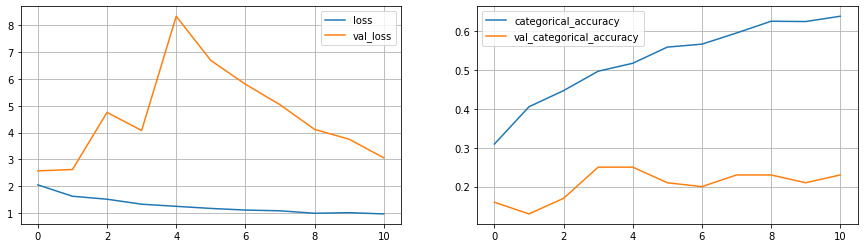

In [105]:
plot(history_model2)

##### We can see  val_loss did not improve from 2.57189so earlystopping stops the epoch automatically!! 

- Best weights save automatically. The validation accuracy of 23% and training accuracy of 63.73%. Next we will try to reduce the filter size and image resolution and see if get better results. Moreover since we see minor oscillations  in loss, let's try lowering the learning rate to 0.0002

## Model 3 
- Reduce filter size to (2,2,2) 
- image resized to 120 x  120, 
- Batch Size = 30 and 
- No. of Epochs = 25

In [15]:
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam

In [107]:
class ModelConv3D3(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))
        
        #optimiser = optimizers.adam(lr=0.0002)
        # Correct initialization for Adam optimizer with specified learning rate
        optimiser =Adam(learning_rate=0.0002) 
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [108]:
conv_3d3=ModelConv3D3()
conv_3d3.initialize_path(project_folder)
conv_3d3.initialize_image_properties(image_height=120,image_width=120)
conv_3d3.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=25)
conv_3d3_model=conv_3d3.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d3_model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_56 (Conv3D)          (None, 16, 120, 120, 16)  400       
                                                                 
 activation_56 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_104 (Ba  (None, 16, 120, 120, 16)  64       
 tchNormalization)                                               
                                                                 
 max_pooling3d_56 (MaxPoolin  (None, 8, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_57 (Conv3D)          (None, 8, 60, 60, 32)     4128      
                                                                 
 activation_57 (Activation)  (None, 8, 60, 60, 32)   

In [109]:
print("Total Params:", conv_3d3_model.count_params())
history_model3=conv_3d3.train_model(conv_3d3_model,augment_data=True)

Total Params: 1762613
model saved to : model_init_2024-05-0108_21_21.302645/model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_categorical_accuracy:.5f}.h5
Epoch 1/25
23/23 [==============================] - ETA: 0s - loss: 2.2292 - categorical_accuracy: 0.3100
Epoch 00001: val_loss improved from inf to 1.86547, saving model to model_init_2024-05-0108_21_21.302645/model-00001-2.22919-0.30995-0.21000.h5
23/23 [==============================] - 57s 2s/step - loss: 2.2292 - categorical_accuracy: 0.3100 - val_loss: 1.8655 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/25
22/23 [===========================>..] - ETA: 2s - loss: 1.5360 - categorical_accuracy: 0.4720
Epoch 00002: val_loss did not improve from 1.86547
23/23 [==============================] - 54s 2s/step - loss: 1.5362 - categorical_accuracy: 0.4729 - val_loss: 2.7406 - val_categorical_accuracy: 0.2300 - lr: 2.0000e-04
Epoch 3/25
23/23 [==============================] - ETA: 0s - loss: 1.3090 - categorica

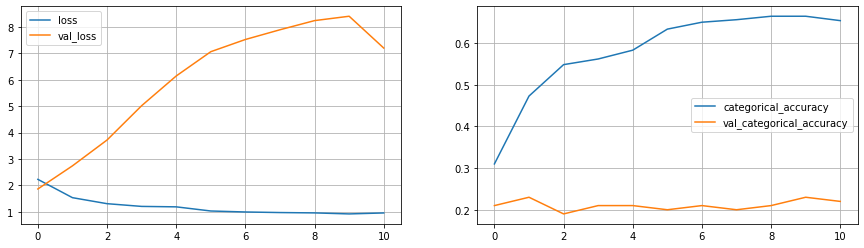

In [110]:
plot(history_model3)

##### Model has a  validation accuracy of 22% and training accuracy of 65% . 
- But we were able to reduce the parameter size by half the earlier model. 
- Let's trying adding more layers

## Model 4 - 
### Adding more layers 
- Batch Size = 20 and 
- No. of Epochs = 25

In [111]:
class ModelConv3D4(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
      
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [113]:
conv_3d4=ModelConv3D4()
conv_3d4.initialize_path(project_folder)
conv_3d4.initialize_image_properties(image_height=120,image_width=120)
conv_3d4.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d4_model=conv_3d4.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d4_model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_68 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_68 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_120 (Ba  (None, 16, 120, 120, 16)  64       
 tchNormalization)                                               
                                                                 
 conv3d_69 (Conv3D)          (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_69 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_121 (Ba  (None, 16, 120, 120, 16)  64       
 tchNormalization)                                   

In [114]:
print("Total Params:", conv_3d4_model.count_params())
history_model4=conv_3d4.train_model(conv_3d4_model,augment_data=True)

Total Params: 2556533
model saved to : model_init_2024-05-0108_33_45.607997/model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_categorical_accuracy:.5f}.h5
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 2.0883 - categorical_accuracy: 0.3680
Epoch 00001: val_loss improved from inf to 3.24704, saving model to model_init_2024-05-0108_33_45.607997/model-00001-2.08833-0.36802-0.16000.h5
34/34 [==============================] - 65s 2s/step - loss: 2.0883 - categorical_accuracy: 0.3680 - val_loss: 3.2470 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.4944 - categorical_accuracy: 0.4842
Epoch 00002: val_loss did not improve from 3.24704
34/34 [==============================] - 55s 2s/step - loss: 1.4944 - categorical_accuracy: 0.4842 - val_loss: 4.2006 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.5233 - categorical_accura

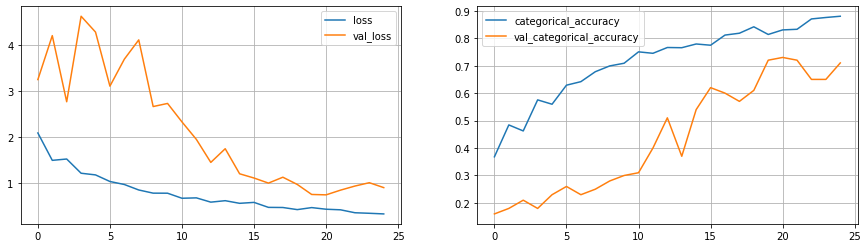

In [ ]:
plot(history_model4)

 

We get a validation accuracy of 71% . 

Let's try adding dropouts at the convolution layers

## Model 5 
### Adding dropout at convolution layers

In [18]:
class ModelConv3D5(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [19]:
conv_3d5=ModelConv3D5()
conv_3d5.initialize_path(project_folder)
conv_3d5.initialize_image_properties(image_height=120,image_width=120)
conv_3d5.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=15)
conv_3d5_model=conv_3d5.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d5_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_20 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_20 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_26 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_21 (Conv3D)          (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_21 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_27 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                     

In [120]:
print("Total Params:", conv_3d5_model.count_params())
history_model5=conv_3d5.train_model(conv_3d5_model,augment_data=True)

Total Params: 2556533
model saved to : model_init_2024-05-0108_58_54.608769/model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_categorical_accuracy:.5f}.h5
Epoch 1/15
34/34 [==============================] - ETA: 0s - loss: 1.7692 - categorical_accuracy: 0.3703
Epoch 00001: val_loss improved from inf to 2.11841, saving model to model_init_2024-05-0108_58_54.608769/model-00001-1.76923-0.37029-0.16000.h5
34/34 [==============================] - 57s 2s/step - loss: 1.7692 - categorical_accuracy: 0.3703 - val_loss: 2.1184 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/15
34/34 [==============================] - ETA: 0s - loss: 1.3103 - categorical_accuracy: 0.5053
Epoch 00002: val_loss did not improve from 2.11841
34/34 [==============================] - 56s 2s/step - loss: 1.3103 - categorical_accuracy: 0.5053 - val_loss: 2.3197 - val_categorical_accuracy: 0.1200 - lr: 0.0010
Epoch 3/15
34/34 [==============================] - ETA: 0s - loss: 1.1763 - categorical_accura

In [ ]:
plot(history_model5)

 #### model is still Overfitting !!
 
 Adding dropouts has further reduced validation accuracy as the model doesn't seem to generalise well.__

##### All the experimental models above have more than 1 million parameters. Let's try to reduce the model size and see the performance

## Model 6 
### Reducing the number of parameters

In [21]:
class ModelConv3D6(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(learning_rate=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [22]:
conv_3d6=ModelConv3D6()
conv_3d6.initialize_path(project_folder)
conv_3d6.initialize_image_properties(image_height=100,image_width=100)
conv_3d6.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=20)
conv_3d6_model=conv_3d6.define_model(dense_neurons=128,dropout=0.25)
conv_3d6_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_28 (Conv3D)          (None, 16, 100, 100, 16)  1312      
                                                                 
 activation_28 (Activation)  (None, 16, 100, 100, 16)  0         
                                                                 
 batch_normalization_36 (Bat  (None, 16, 100, 100, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 8, 50, 50, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_29 (Conv3D)          (None, 8, 50, 50, 32)     4128      
                                                                 
 activation_29 (Activation)  (None, 8, 50, 50, 32)    

In [23]:
print("Total Params:", conv_3d6_model.count_params())
history_model6=conv_3d6.train_model(conv_3d6_model,augment_data=True)

Total Params: 696645
model saved to : model_init_2024-05-0110_01_09.445879/model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_categorical_accuracy:.5f}.h5
Epoch 1/20


2024-05-01 10:01:13.117764: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


34/34 [==============================] - ETA: 0s - loss: 1.7990 - categorical_accuracy: 0.3710
Epoch 00001: val_loss improved from inf to 2.12475, saving model to model_init_2024-05-0110_01_09.445879/model-00001-1.79904-0.37104-0.16000.h5
34/34 [==============================] - 55s 2s/step - loss: 1.7990 - categorical_accuracy: 0.3710 - val_loss: 2.1248 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.1908 - categorical_accuracy: 0.5490
Epoch 00002: val_loss did not improve from 2.12475
34/34 [==============================] - 53s 2s/step - loss: 1.1908 - categorical_accuracy: 0.5490 - val_loss: 3.6038 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.0205 - categorical_accuracy: 0.6109
Epoch 00003: val_loss did not improve from 2.12475
34/34 [==============================] - 53s 2s/step - loss: 1.0205 - categorical_accuracy: 0.6109 - val_lo

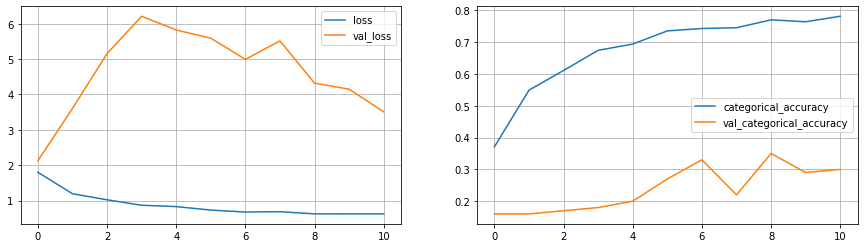

In [26]:
plot(history_model6)

#### The above low memory/compact model records a validation accuracy of 30%.

reduce the model size and see the performance

## Model 7 - Reducing the number of parameters again

In [27]:
class ModelConv3D7(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(learning_rate=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [28]:
conv_3d7=ModelConv3D7()
conv_3d7.initialize_path(project_folder)
conv_3d7.initialize_image_properties(image_height=120,image_width=120)
conv_3d7.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d7_model=conv_3d7.define_model(dense_neurons=64,dropout=0.25)
conv_3d7_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_32 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_32 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_42 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_20 (MaxPoolin  (None, 8, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_33 (Conv3D)          (None, 8, 60, 60, 32)     13856     
                                                                 
 activation_33 (Activation)  (None, 8, 60, 60, 32)    

In [29]:
print("Total Params:", conv_3d7_model.count_params())
history_model7=conv_3d7.train_model(conv_3d7_model,augment_data=True)

Total Params: 504709
model saved to : model_init_2024-05-0110_14_51.309921/model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_categorical_accuracy:.5f}.h5
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.8558 - categorical_accuracy: 0.3446
Epoch 00001: val_loss improved from inf to 1.85189, saving model to model_init_2024-05-0110_14_51.309921/model-00001-1.85580-0.34465-0.21000.h5
34/34 [==============================] - 62s 2s/step - loss: 1.8558 - categorical_accuracy: 0.3446 - val_loss: 1.8519 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.2553 - categorical_accuracy: 0.5249
Epoch 00002: val_loss did not improve from 1.85189
34/34 [==============================] - 58s 2s/step - loss: 1.2553 - categorical_accuracy: 0.5249 - val_loss: 2.3874 - val_categorical_accuracy: 0.1800 - lr: 2.0000e-04
Epoch 3/25
33/34 [============================>.] - ETA: 1s - loss: 1.0982 - categorical

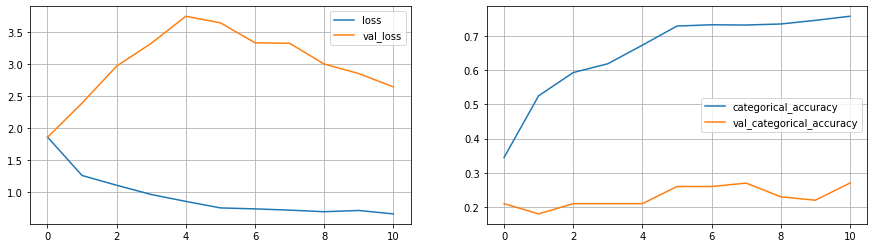

In [30]:
plot(history_model7)

### For the above compact model the validation accuracy of 27% only

## Model 8 - CNN- LSTM Model

In [41]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam 

In [46]:
class RNNCNN1(ModelBuilder):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        #model.add(TimeDistributed(Conv2D(512, (2, 2) , padding='valid', activation='relu')))
       # model.add(TimeDistributed(BatchNormalization()))
       # model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = "adam"
       # optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [47]:
rnn_cnn1=RNNCNN1()
rnn_cnn1.initialize_path(project_folder)
rnn_cnn1.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn1.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn1_model=rnn_cnn1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn1_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_48 (TimeDi  (None, 18, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_49 (TimeDi  (None, 18, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_50 (TimeDi  (None, 18, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_51 (TimeDi  (None, 18, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_52 (TimeDi  (None, 18, 60, 60, 32)  

In [48]:
print("Total Params:", rnn_cnn1_model.count_params())

history_model8=rnn_cnn1.train_model(rnn_cnn1_model,augment_data=True)
 

Total Params: 1657445
model saved to : model_init_2024-05-0110_49_58.137167/model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_categorical_accuracy:.5f}.h5
Epoch 1/20
33/34 [============================>.] - ETA: 1s - loss: 1.3647 - categorical_accuracy: 0.4212
Epoch 00001: val_loss improved from inf to 1.59840, saving model to model_init_2024-05-0110_49_58.137167/model-00001-1.36601-0.42081-0.25000.h5
34/34 [==============================] - 68s 2s/step - loss: 1.3660 - categorical_accuracy: 0.4208 - val_loss: 1.5984 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.1259 - categorical_accuracy: 0.5498
Epoch 00002: val_loss did not improve from 1.59840
34/34 [==============================] - 62s 2s/step - loss: 1.1259 - categorical_accuracy: 0.5498 - val_loss: 2.1301 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 3/20
33/34 [============================>.] - ETA: 1s - loss: 0.9430 - categorical_accura

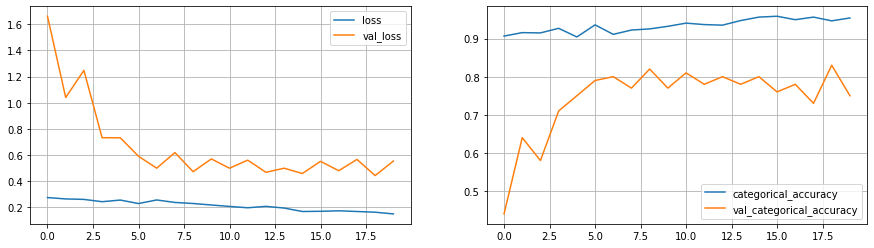

In [59]:
plot(history_model8)

#### For CNN - LSTM model we get a best validation accuracy of 80%

As we see more cases of overfitting, lets augment the data with **slight rotation** as well and run the same set of models again

## Let's apply some data augmentation & check the model performance.

In [49]:
class ModelBuilderMoreAugmentation(metaclass= abc.ABCMeta):
    
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                #image_resized=cv2.resize(image,(self.image_height,self.image_width,3))
                image_resized = cv2.resize(image, (self.image_width, self.image_height))

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=cv2.resize(cropped,(self.image_width, self.image_height))
                     
                    M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch') # period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None,  initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass
    
    

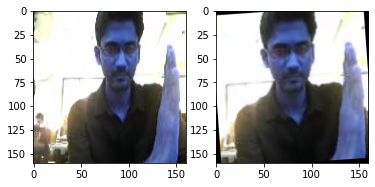

In [50]:
class Test(ModelBuilderMoreAugmentation):
    def define_model(self):
        pass

test_generator=Test()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=160,image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,29,:,:,:])   
axes[1].imshow(batch_data[3,29,:,:,:]) 
plt.show()

## Model 9 (applying Augmentation)
- (3,3,3) Filter & 
- 160x160 Image resolution - similar to Model 2

In [45]:
class ModelConv3D9(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = Adam(learning_rate=0.0002) 
        #optimiser = optimizers.Adam(learning_rate=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [46]:
conv_3d9=ModelConv3D9()
conv_3d9.initialize_path(project_folder)
conv_3d9.initialize_image_properties(image_height=160,image_width=160)
conv_3d9.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=20)
conv_3d9_model=conv_3d9.define_model(dense_neurons=256,dropout=0.5)
conv_3d9_model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_56 (Conv3D)          (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_56 (Activation)  (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_85 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_48 (MaxPoolin  (None, 10, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_57 (Conv3D)          (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_57 (Activation)  (None, 10, 80, 80, 32)  

In [ ]:
print("Total Params:", conv_3d9_model.count_params())
history_model9=conv_3d9.train_model(conv_3d9_model,augment_data=True)

Total Params: 3638981
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.9567 - categorical_accuracy: 0.3952
Epoch 00001: saving model to model_init_2024-04-3016_05_18.469112/model-00001-1.95669-0.39517-2.33965-0.21000.keras
34/34 [==============================] - 107s 3s/step - loss: 1.9567 - categorical_accuracy: 0.3952 - val_loss: 2.3396 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.4467 - categorical_accuracy: 0.5053
Epoch 00002: saving model to model_init_2024-04-3016_05_18.469112/model-00002-1.44672-0.50528-4.19185-0.22000.keras
34/34 [==============================] - 103s 3s/step - loss: 1.4467 - categorical_accuracy: 0.5053 - val_loss: 4.1918 - val_categorical_accuracy: 0.2200 - lr: 2.0000e-04
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.2379 - categorical_accuracy: 0.5520
Epoch 00003: saving model to model_init_2024-04-3016_05_18.469112/model-00003-1.23785-

In [ ]:
plot(history_model9)

## Model 10 (applying Augmentation)
- (2,2,2) Filter  
- 120x120 Image resolution 
- similar to Model 3

In [51]:
class ModelConv3D10(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = Adam(learning_rate=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [52]:
conv_3d10=ModelConv3D10()
conv_3d10.initialize_path(project_folder)
conv_3d10.initialize_image_properties(image_height=120,image_width=120)
conv_3d10.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=25)
conv_3d10_model=conv_3d10.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d10_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_64 (Conv3D)          (None, 16, 120, 120, 16)  400       
                                                                 
 activation_64 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_97 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_56 (MaxPoolin  (None, 8, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_65 (Conv3D)          (None, 8, 60, 60, 32)     4128      
                                                                 
 activation_65 (Activation)  (None, 8, 60, 60, 32)   

In [53]:
print("Total Params:", conv_3d10_model.count_params())
history_model10=conv_3d10.train_model(conv_3d10_model,augment_data=True)

Total Params: 1762613
Epoch 1/25
22/23 [===========================>..] - ETA: 2s - loss: 2.1688 - categorical_accuracy: 0.2932
Epoch 00001: saving model to model_init_2024-04-3016_50_37.392388/model-00001-2.17023-0.29412-1.80407-0.16000.keras
23/23 [==============================] - 60s 3s/step - loss: 2.1702 - categorical_accuracy: 0.2941 - val_loss: 1.8041 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/25
22/23 [===========================>..] - ETA: 2s - loss: 1.4853 - categorical_accuracy: 0.4742
Epoch 00002: saving model to model_init_2024-04-3016_50_37.392388/model-00002-1.48799-0.47436-2.41342-0.22000.keras
23/23 [==============================] - 59s 3s/step - loss: 1.4880 - categorical_accuracy: 0.4744 - val_loss: 2.4134 - val_categorical_accuracy: 0.2200 - lr: 2.0000e-04
Epoch 3/25
23/23 [==============================] - ETA: 0s - loss: 1.3317 - categorical_accuracy: 0.5422
Epoch 00003: saving model to model_init_2024-04-3016_50_37.392388/model-00003-1.33174-0.

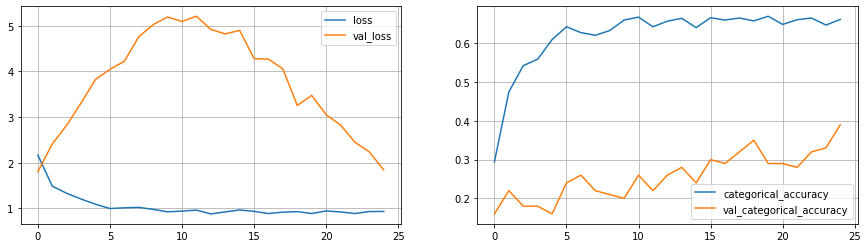

In [54]:
plot(history_model10)

## Model 11 (using Augmentation)
- Adding more layers 
- Similar to model 4

In [55]:
class ModelConv3D11(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = Adam(learning_rate=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [56]:
conv_3d11=ModelConv3D11()
conv_3d11.initialize_path(project_folder)
conv_3d11.initialize_image_properties(image_height=120,image_width=120)
conv_3d11.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d11_model=conv_3d11.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d11_model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_68 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_68 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_103 (Ba  (None, 16, 120, 120, 16)  64       
 tchNormalization)                                               
                                                                 
 conv3d_69 (Conv3D)          (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_69 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_104 (Ba  (None, 16, 120, 120, 16)  64       
 tchNormalization)                                   

In [57]:
print("Total Params:", conv_3d11_model.count_params())
history_model11=conv_3d11.train_model(conv_3d11_model,augment_data=True)

Total Params: 2556533
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 2.0352 - categorical_accuracy: 0.3394
Epoch 00001: saving model to model_init_2024-04-3017_15_54.541729/model-00001-2.03523-0.33937-1.84800-0.16000.keras
34/34 [==============================] - 69s 2s/step - loss: 2.0352 - categorical_accuracy: 0.3394 - val_loss: 1.8480 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.5697 - categorical_accuracy: 0.4630
Epoch 00002: saving model to model_init_2024-04-3017_15_54.541729/model-00002-1.56971-0.46305-2.24790-0.17000.keras
34/34 [==============================] - 60s 2s/step - loss: 1.5697 - categorical_accuracy: 0.4630 - val_loss: 2.2479 - val_categorical_accuracy: 0.1700 - lr: 2.0000e-04
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.3451 - categorical_accuracy: 0.5407
Epoch 00003: saving model to model_init_2024-04-3017_15_54.541729/model-00003-1.34514-0.

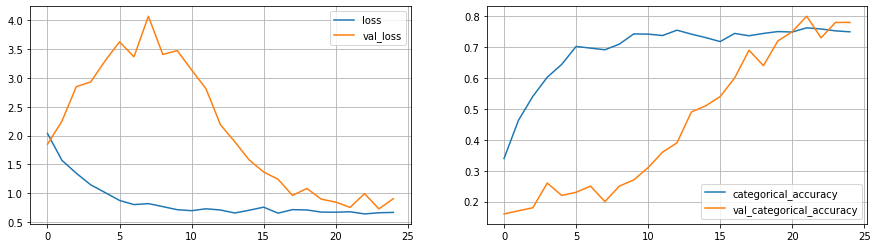

In [58]:
plot(history_model11)

## Model 12 (using Augmentation)
- Adding dropouts 
- Similar to Model 5

In [59]:
class ModelConv3D12(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = Adam(learning_rate=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [60]:
conv_3d12=ModelConv3D12()
conv_3d12.initialize_path(project_folder)
conv_3d12.initialize_image_properties(image_height=120,image_width=120)
conv_3d12.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d12_model=conv_3d12.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d12_model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_76 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_76 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_113 (Ba  (None, 16, 120, 120, 16)  64       
 tchNormalization)                                               
                                                                 
 conv3d_77 (Conv3D)          (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_77 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_114 (Ba  (None, 16, 120, 120, 16)  64       
 tchNormalization)                                   

In [61]:
print("Total Params:", conv_3d12_model.count_params())
history_model12=conv_3d12.train_model(conv_3d12_model,augment_data=True)

Total Params: 2556533
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.9097 - categorical_accuracy: 0.3439
Epoch 00001: saving model to model_init_2024-04-3017_41_37.769105/model-00001-1.90974-0.34389-2.08477-0.21000.keras
34/34 [==============================] - 63s 2s/step - loss: 1.9097 - categorical_accuracy: 0.3439 - val_loss: 2.0848 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.4817 - categorical_accuracy: 0.4525
Epoch 00002: saving model to model_init_2024-04-3017_41_37.769105/model-00002-1.48167-0.45249-2.72934-0.18000.keras
34/34 [==============================] - 65s 2s/step - loss: 1.4817 - categorical_accuracy: 0.4525 - val_loss: 2.7293 - val_categorical_accuracy: 0.1800 - lr: 2.0000e-04
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.3338 - categorical_accuracy: 0.4985
Epoch 00003: saving model to model_init_2024-04-3017_41_37.769105/model-00003-1.33379-0.

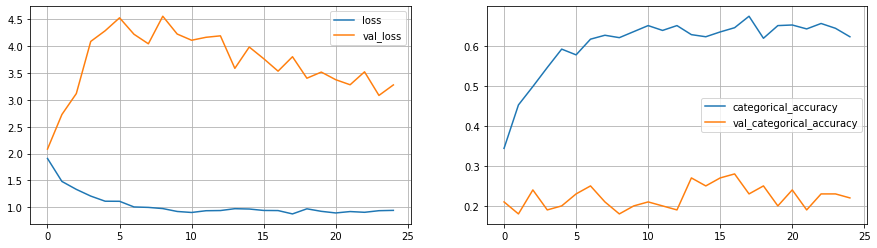

In [ ]:
plot(history_model12)

#### Model is overfitting badly !!

## Model 13 (aplying Augmentation)
- Reducing network parameters 
- Similar to Model 6

In [65]:
class ModelConv3D13(ModelBuilderMoreAugmentation):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = Adam(learning_rate=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [66]:
conv_3d13=ModelConv3D13()
conv_3d13.initialize_path(project_folder)
conv_3d13.initialize_image_properties(image_height=100,image_width=100)
conv_3d13.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d13_model=conv_3d13.define_model(dense_neurons=128,dropout=0.25)
conv_3d13_model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_88 (Conv3D)          (None, 16, 100, 100, 16)  1312      
                                                                 
 activation_88 (Activation)  (None, 16, 100, 100, 16)  0         
                                                                 
 batch_normalization_129 (Ba  (None, 16, 100, 100, 16)  64       
 tchNormalization)                                               
                                                                 
 max_pooling3d_72 (MaxPoolin  (None, 8, 50, 50, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_89 (Conv3D)          (None, 8, 50, 50, 32)     4128      
                                                                 
 activation_89 (Activation)  (None, 8, 50, 50, 32)   

In [67]:
print("Total Params:", conv_3d13_model.count_params())
history_model13=conv_3d13.train_model(conv_3d13_model,augment_data=True)

Total Params: 696645
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.7798 - categorical_accuracy: 0.3462
Epoch 00001: saving model to model_init_2024-04-3018_07_20.466556/model-00001-1.77984-0.34615-1.94857-0.16000.keras
34/34 [==============================] - 57s 2s/step - loss: 1.7798 - categorical_accuracy: 0.3462 - val_loss: 1.9486 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.1895 - categorical_accuracy: 0.5528
Epoch 00002: saving model to model_init_2024-04-3018_07_20.466556/model-00002-1.18952-0.55279-2.82181-0.17000.keras
34/34 [==============================] - 56s 2s/step - loss: 1.1895 - categorical_accuracy: 0.5528 - val_loss: 2.8218 - val_categorical_accuracy: 0.1700 - lr: 2.0000e-04
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.0175 - categorical_accuracy: 0.6116
Epoch 00003: saving model to model_init_2024-04-3018_07_20.466556/model-00003-1.01746-0.6

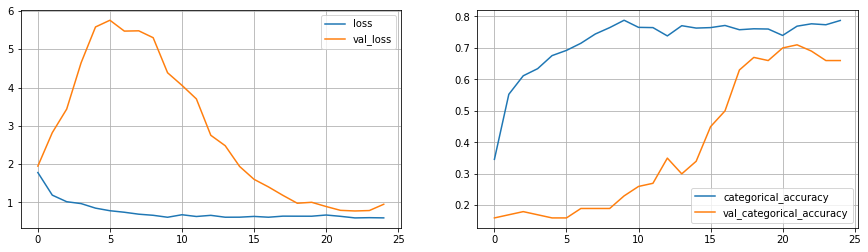

In [68]:
plot(history_model13)

## Model 14 with Augmentation
- Reducing network parameters again 
- Similar to model 7

In [57]:
class ModelConv3D14(ModelBuilderMoreAugmentation):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [79]:
conv_3d14=ModelConv3D14()
conv_3d14.initialize_path(project_folder)
conv_3d14.initialize_image_properties(image_height=120,image_width=120)
conv_3d14.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d14_model=conv_3d14.define_model(dense_neurons=64,dropout=0.25)
conv_3d14_model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_44 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_44 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_87 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_32 (MaxPoolin  (None, 8, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_45 (Conv3D)          (None, 8, 60, 60, 32)     13856     
                                                                 
 activation_45 (Activation)  (None, 8, 60, 60, 32)   

In [59]:
print("Total Params:", conv_3d14_model.count_params())
history_model14=conv_3d14.train_model(conv_3d14_model,augment_data=True)

Total Params: 504709
Epoch 1/25
33/34 [============================>.] - ETA: 1s - loss: 1.7077 - categorical_accuracy: 0.3795
Epoch 00001: saving model to model_init_2024-05-0111_16_26.779005/model-00001-1.71020-0.37858-1.76818-0.21000.keras
34/34 [==============================] - 60s 2s/step - loss: 1.7102 - categorical_accuracy: 0.3786 - val_loss: 1.7682 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.2056 - categorical_accuracy: 0.5241
Epoch 00002: saving model to model_init_2024-05-0111_16_26.779005/model-00002-1.20564-0.52413-2.31850-0.13000.keras
34/34 [==============================] - 57s 2s/step - loss: 1.2056 - categorical_accuracy: 0.5241 - val_loss: 2.3185 - val_categorical_accuracy: 0.1300 - lr: 2.0000e-04
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.0866 - categorical_accuracy: 0.5664
Epoch 00003: saving model to model_init_2024-05-0111_16_26.779005/model-00003-1.08661-0.5

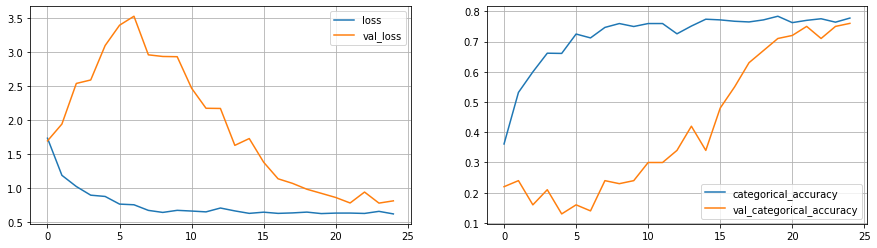

In [76]:
plot(history_model14)

## Model 15 (using Augmentation)
### CNN LSTM with GRU 


In [60]:
class RNNCNN2(ModelBuilderMoreAugmentation):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Flatten()))


        model.add(GRU(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [61]:
rnn_cnn2=RNNCNN2()
rnn_cnn2.initialize_path(project_folder)
rnn_cnn2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn2.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn2_model=rnn_cnn2.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn2_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_64 (TimeDi  (None, 18, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_65 (TimeDi  (None, 18, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_66 (TimeDi  (None, 18, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_67 (TimeDi  (None, 18, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_68 (TimeDi  (None, 18, 60, 60, 32) 

In [79]:
print("Total Params:", rnn_cnn2_model.count_params())
history_model15=rnn_cnn2.train_model(rnn_cnn2_model,augment_data=True)

Total Params: 2573925
Epoch 1/20
33/34 [============================>.] - ETA: 1s - loss: 1.5179 - categorical_accuracy: 0.3523
Epoch 00001: saving model to model_init_2024-04-3019_03_18.389177/model-00001-1.51484-0.35370-1.81744-0.21000.keras
34/34 [==============================] - 71s 2s/step - loss: 1.5148 - categorical_accuracy: 0.3537 - val_loss: 1.8174 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.0265 - categorical_accuracy: 0.5882
Epoch 00002: saving model to model_init_2024-04-3019_03_18.389177/model-00002-1.02648-0.58824-2.78914-0.20000.keras
34/34 [==============================] - 69s 2s/step - loss: 1.0265 - categorical_accuracy: 0.5882 - val_loss: 2.7891 - val_categorical_accuracy: 0.2000 - lr: 2.0000e-04
Epoch 3/20
33/34 [============================>.] - ETA: 1s - loss: 0.8736 - categorical_accuracy: 0.6636
Epoch 00003: saving model to model_init_2024-04-3019_03_18.389177/model-00003-0.87422-0.

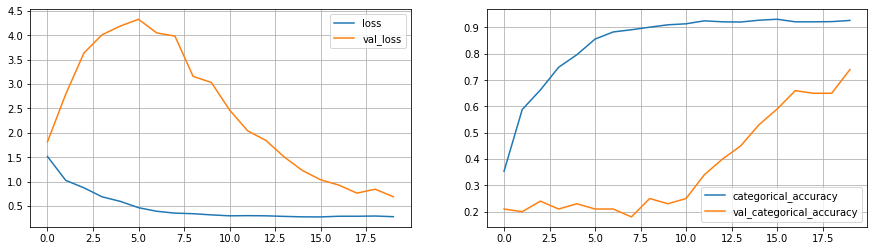

In [80]:
plot(history_model15)

### Augmenting more leads to significant overfitting, but doesn't yield much improvement in accuracy.

## Model 16 - Let's introduce Transfer Learning! 
__(Optional)__

In [62]:
#importing the MobileNet model due to it's lightweight architecture and high speed performance as compared 
# to other heavy-duty models like VGG16, Alexnet, InceptionV3 etc. Also, we are now also running on low disk space 
# in the nimblebox.ai platform. 

from keras.applications import mobilenet

In [63]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL(ModelBuilderMoreAugmentation):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        
        
        for layer in model.layers:
            layer.trainable = False
        
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [64]:
rnn_cnn_tl=RNNCNN_TL()
rnn_cnn_tl.initialize_path(project_folder)
rnn_cnn_tl.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl_model=rnn_cnn_tl.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_77 (TimeDi  (None, 16, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_78 (TimeDi  (None, 16, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_79 (TimeDi  (None, 16, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_80 (TimeDi  (None, 16, 1024)         0         
 stributed)                                                      
                                                                 
 lstm_4 (LSTM)               (None, 128)             

In [84]:
print("Total Params:", rnn_cnn_tl_model.count_params())
history_model16=rnn_cnn_tl.train_model(rnn_cnn_tl_model,augment_data=True)

Total Params: 3840453
Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 1.4054 - categorical_accuracy: 0.3884
Epoch 00001: saving model to model_init_2024-04-3019_26_16.669971/model-00001-1.40540-0.38839-1.02390-0.59000.keras
133/133 [==============================] - 66s 474ms/step - loss: 1.4054 - categorical_accuracy: 0.3884 - val_loss: 1.0239 - val_categorical_accuracy: 0.5900 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.9387 - categorical_accuracy: 0.6410
Epoch 00002: saving model to model_init_2024-04-3019_26_16.669971/model-00002-0.93866-0.64103-0.78084-0.70000.keras
133/133 [==============================] - 59s 450ms/step - loss: 0.9387 - categorical_accuracy: 0.6410 - val_loss: 0.7808 - val_categorical_accuracy: 0.7000 - lr: 0.0010
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 0.7180 - categorical_accuracy: 0.7247
Epoch 00003: saving model to model_init_2024-04-3019_26_16.669971/model-00003-0.

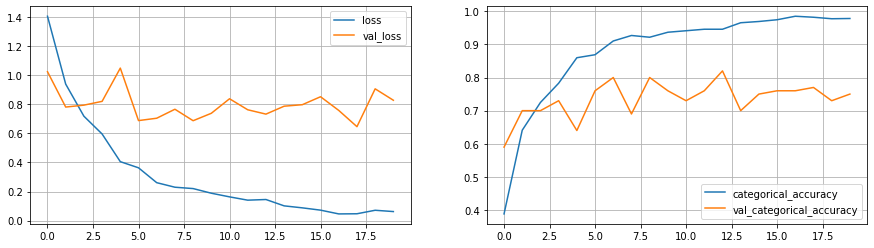

In [86]:
plot(history_model16)

##### We are not training the mobilenet weights and we see validation accuracy is very poor. Let's train them as well and observe if there is performance improvement

## Model 17 - Transfer Learning with GRU and training all weights
__(Optional)__

In [65]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL2(ModelBuilderMoreAugmentation):
    
    def define_model(self,gru_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
 
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [66]:
rnn_cnn_tl2=RNNCNN_TL2()
rnn_cnn_tl2.initialize_path(project_folder)
rnn_cnn_tl2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl2.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl2_model=rnn_cnn_tl2.define_model(gru_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl2_model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_81 (TimeDi  (None, 16, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_82 (TimeDi  (None, 16, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_83 (TimeDi  (None, 16, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_84 (TimeDi  (None, 16, 1024)         0         
 stributed)                                                      
                                                                 
 gru_1 (GRU)                 (None, 128)             

In [67]:
print("Total Params:", rnn_cnn_tl2_model.count_params())
history_model17=rnn_cnn_tl2.train_model(rnn_cnn_tl2_model,augment_data=True)

Total Params: 3693253
Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 1.2139 - categorical_accuracy: 0.5030
Epoch 00001: saving model to model_init_2024-05-0111_45_44.385757/model-00001-1.21390-0.50302-0.59928-0.77000.keras
133/133 [==============================] - 62s 435ms/step - loss: 1.2139 - categorical_accuracy: 0.5030 - val_loss: 0.5993 - val_categorical_accuracy: 0.7700 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.7191 - categorical_accuracy: 0.7172
Epoch 00002: saving model to model_init_2024-05-0111_45_44.385757/model-00002-0.71914-0.71719-0.34239-0.90000.keras
133/133 [==============================] - 56s 422ms/step - loss: 0.7191 - categorical_accuracy: 0.7172 - val_loss: 0.3424 - val_categorical_accuracy: 0.9000 - lr: 0.0010
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 0.4976 - categorical_accuracy: 0.8167
Epoch 00003: saving model to model_init_2024-05-0111_45_44.385757/model-00003-0.

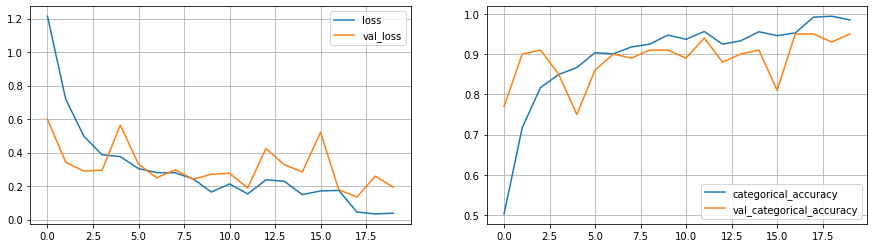

In [69]:
plot(history_model17)

98% Training accuracy and 95% validation accuracy


## Two models seems better : 

#### Model 14 - CNN+LSTM, which performed well.
-  Training Accuracy : 78%
- Validation Accuracy : 73%)
- Number of Parameters(1,657,445)less according to other models performance

#### Model 17 - Transfer Learning with GRU and training all weights

- Training Accuracy : 98% 
- Validation Accuracy : 95%
-Total params: 3,693,253



we considered this weight for model testing, Let's have look at the performance below

# Loading model and Testing

### Testing Model 17 - Transfer Learning with GRU 

In [72]:

import time
from keras.models import load_model
#model = load_model(r"model-00008-0.36909-0.87934-0.77384-0.70000.keras")
#model = load_model("model-00020-0.1488-0.9585-0.8000.keras")

model=load_model("model_init_2024-05-0111_45_44.385757/model-00020-0.03856-0.98492-0.19338-0.95000.keras")

In [76]:
test_generator=RNNCNN_TL2()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=120,image_width=120)
test_generator.initialize_hyperparams(frames_to_sample=16,batch_size=15,num_epochs=20)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=False)
batch_data, batch_labels=next(g)

In [77]:
batch_labels

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [78]:
print(np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1))

[3 2 3 1 4 0 2 1 1 0 2 2 0 0 0]


### Conclusion:
#### Model 17: Transfer Learning with GRU (Training All Weights)
 - Training Accuracy: 98%
 - Validation Accuracy: 95%
 - Total Parameters: 3,693,253
##### Model 17 demonstrates excellent accuracy in both training and validation, achieving high performance with a considerable parameter count. The use of transfer learning with GRU while training all weights contributes to its strong results.
    